# Stochastic tools tutorial

This module contains some practical functions that help the user to quickly compute useful quantities related to stochastic gravitational wave searches such as:

- Overlap Reduction Function (ORF).
- Power-Law integrated Sensitivity (PLS).
- Minimum frequency and mimium value of the PLS of a given configuration.
- Signal-to-noise ratio (SNR) of a given stochastic background spectrum.
- Mimimum detectable energy density by a single detector.

In the following we will see how to use these functions and access their output.

In [1]:
# Let's start by importing the necessary libraries
import numpy as np
import copy
import pylab as plt
from matplotlib import cm
import os
import sys

PACKAGE_PARENT = "../gwfast"
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

from gwfast.stochastic import stochasticTools as st
import gwfast.gwfastGlobals as glob

In [2]:
# Set the plot appearence
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.size": 15,
    }
)

In [3]:
# First we take the default detectors from GWFAST
alldetectors = copy.deepcopy(glob.detectors)

# We then set the frequency grid over which we want to compute the ORF and the PLS.
fmin = 2.
fmax = 2048.
df = 2.**(-3.)
fgrid = np.arange(fmin, fmax+df, df)

# It is essential to provide a PSD for each detector you would like to consider. 
# We store them in a dictionary of paths pointing at each of them
# Change path style according to previous notebooks
psd_paths = {
    "ETS": "../psds/ET_designs_comparison_paper/HFLF_cryo/ETLength10km.txt",
    "CE1Id": "../psds/ce_strain/cosmic_explorer.txt",
    "CE2NM": "../psds/ce_strain/cosmic_explorer_20km.txt",
}

# From the copy we made at the beginning, we select the detectors we are interested in.
# We update them with their PSD path and, for the sake of the next computation, we
# set the length of the arms (specific of T-shaped detectors, not necessary for L-shaped).
my_dets = {det: alldetectors[det] for det in psd_paths.keys()}
for det in psd_paths.keys():
    my_dets[det]["psd_path"] = psd_paths[det]
    if my_dets[det]["shape"] == "T":
        my_dets[det]["arm_length"] = 10 # Km

# Overlap Reduction Function

In [4]:
# We start by accessing the ORF of the detector pairs in our network
# Let us first consider CE1Id and CE2NM
det1_name = "CE1Id"
det2_name = "CE2NM"
det1 = my_dets[det1_name]
det2 = my_dets[det2_name]
orf = st.overlap_reduction_function(f=fgrid,
                                    det1=det1,
                                    det2=det2,
                                    det1_name=det1_name,
                                    det2_name=det2_name
                                   )
# The output is a dictionary 
# containing the detector pair based on the provided names as keys 
# and its orf as a values
print(f"Output dtype: {type(orf)}")
print(f"Output keys: {orf.keys()}")
print(f"Output values: {orf.values()}")

Output dtype: <class 'dict'>
Output keys: dict_keys(['CE1Id-CE2NM'])
Output values: dict_values([array([-0.36772254, -0.36770521, -0.36768683, ...,  0.00288282,
        0.00286253,  0.00284222])])


In [5]:
# Let us now consider the case where there is a triangular-shape detector as input.
det1_name = "ETS"
det2_name = "CE1Id"
det1 = my_dets[det1_name]
det2 = my_dets[det2_name]
# In this case, we need to specify the arm length.
orf = st.overlap_reduction_function(f=fgrid,
                                    det1=det1,
                                    det2=det2,
                                    det1_name=det1_name,
                                    det2_name=det2_name,
                                    arm_length_1=det1["arm_length"],
                                   )
# We now see that the dictionary contains all the detector pairs, 
# including the individual detectors within the triangle.
print(list(orf.keys()))

['ETS_0-CE1Id', 'ETS_1-CE1Id', 'ETS_2-CE1Id', 'ETS_0-ETS_1', 'ETS_0-ETS_2', 'ETS_1-ETS_2']


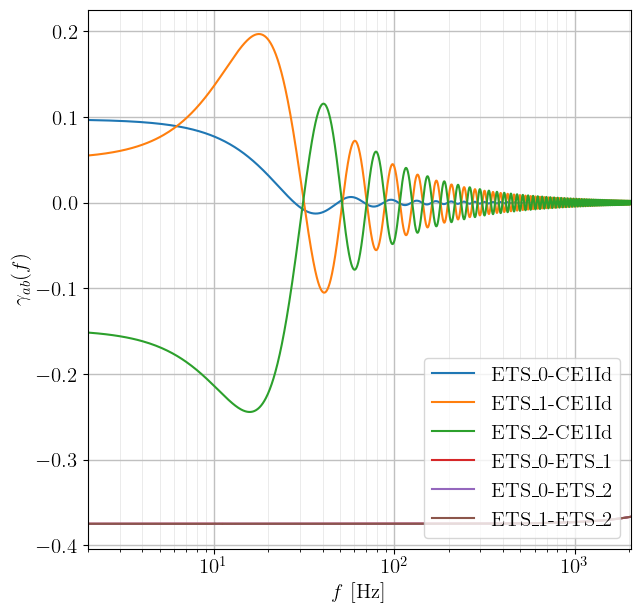

In [6]:
# Let's have a look at them.
fig, ax = plt.subplots(1,1,figsize=(7, 7))
for pair in orf.keys():
    ax.plot(fgrid, orf[pair], label=pair)
ax.set_xlabel(r"$f$ [Hz]")
ax.set_xlim([fgrid[0], fgrid[-1]])
ax.set_ylabel(r"$\gamma_{ab}(f)$")
ax.set_xscale("log")
ax.grid(visible=True, which="major", color="silver", linewidth="1", linestyle="-")
ax.grid(visible=True, which="minor", color="gainsboro", linewidth="0.4", linestyle="-")
ax.legend(loc="lower right")
plt.show()

# Power-Law integrated Sensitivity

There are a couple of functions that can return the PLS.

## Exact PLS

The first one is based on the method presented in [Belgacem (2024)](tmplink) UPDATE LINK

In [7]:
f, pls_exact = st.powerlaw_integrated_sensitivity(fmin=fmin,
                                                  fmax=fmax,
                                                  Net=my_dets,
                                                  H0=67.66,
                                                  Tobs=1.,
                                                  return_all=False,
                                                 )
# Notice the warning printed and act accordingly if desired.

In [8]:
# The output in this case is a dictionary containing
# the PLS of the entire network. If a triangular detector is within it
# this function will return its PLS as well in a separate key.
print(pls_exact)

{'net': array([7.49229182e-09, 7.47994575e-09, 7.46760695e-09, ...,
       1.66135921e-06, 1.66182608e-06, 1.66229283e-06])}


## Thrane-Romano PLS

The second one is based on the method presented in [Thrane, Romano (2013)](https://arxiv.org/abs/1310.5300)

In [9]:
pls_TR = st.powerlaw_integrated_sensitivity_TR(f=fgrid,
                                               Net=my_dets,
                                               H0=67.66,
                                               Tobs=1.,
                                               return_all=False,
                                              )

On a practical level, the key difference is that the first method returns two dictionaries: one containing the frequency arrays for each computed PLS and another one containing the associated PLS values. On the other hand, the second method returns the PLS evaluated on a custom frequency grid.

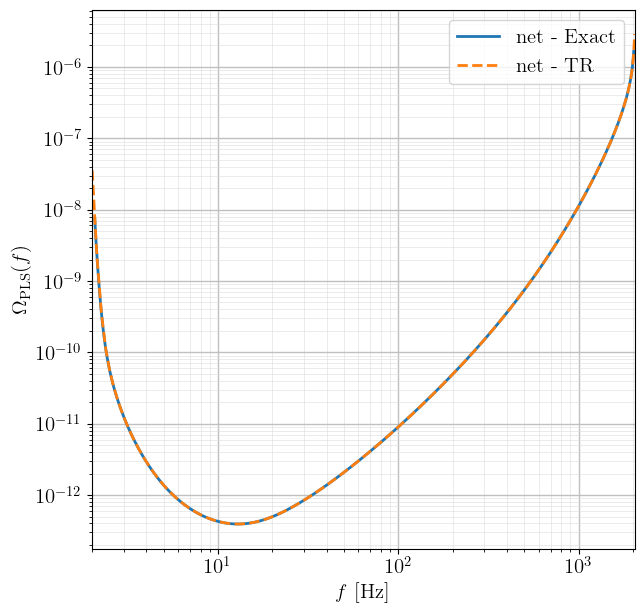

In [10]:
# Let's check their agreement graphically
fig, ax = plt.subplots(1,1,figsize=(7,7))
for key in pls_exact.keys():
    ax.loglog(f[key], pls_exact[key], lw=2., label=r"%s - Exact" % key)
    ax.loglog(fgrid, pls_TR[key], lw=2., linestyle="--", label=r"%s - TR" % key)
    
ax.set_xlabel(r"$f$ [Hz]")
ax.set_xlim([fgrid[0], fgrid[-1]])
ax.set_ylabel(r"$\Omega_{\rm PLS}(f)$")
ax.grid(visible=True, which="major", color="silver", linewidth="1", linestyle="-")
ax.grid(visible=True, which="minor", color="gainsboro", linewidth="0.4", linestyle="-")
ax.legend()

One could also return the PLS for each detector pair involved in the network by setting the `return_all` flag to `True`. Here is an example:

In [11]:
f, pls_exact = st.powerlaw_integrated_sensitivity(fmin=fmin,
                                                  fmax=fmax,
                                                  Net=my_dets,
                                                  H0=67.66,
                                                  Tobs=1.,
                                                  return_all=True,
                                                  verbose=True,
                                                 )
# By default, verbose=False. Set this key to True, as in this example, if you need more insight about the output.

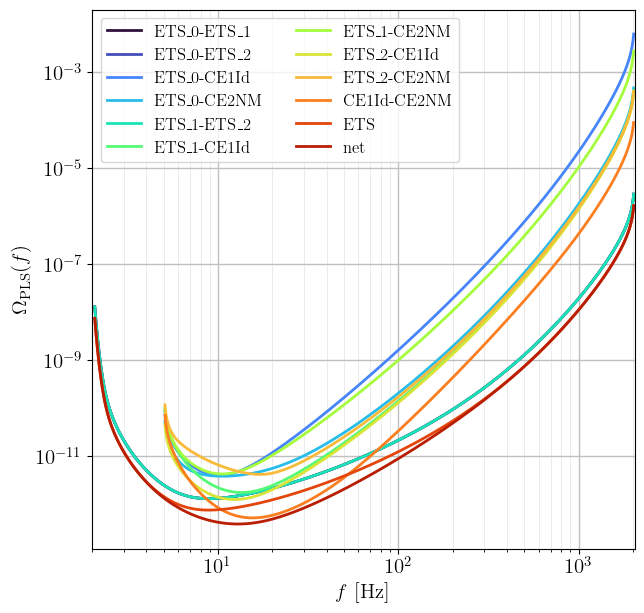

In [12]:
cmap = cm.turbo
colors = {key: cmap(list(pls_exact.keys()).index(key)/len(list(pls_exact.keys()))) for key in pls_exact.keys()}
fig, ax = plt.subplots(1,1,figsize=(7,7))
for key in pls_exact.keys():
    ax.loglog(f[key], pls_exact[key], lw=2., color=colors[key], label=r"%s" % key)
    
ax.set_xlabel(r"$f$ [Hz]")
ax.set_xlim([fgrid[0], fgrid[-1]])
ax.set_ylabel(r"$\Omega_{\rm PLS}(f)$")
ax.grid(visible=True, which="major", color="silver", linewidth="1", linestyle="-")
ax.grid(visible=True, which="minor", color="gainsboro", linewidth="0.4", linestyle="-")
ax.legend(fontsize=12, ncols=2)

We could also access the coordinates of the minimum of each PLS computed by calling the `powerlaw_integrated_sensitivity_minimum` function:

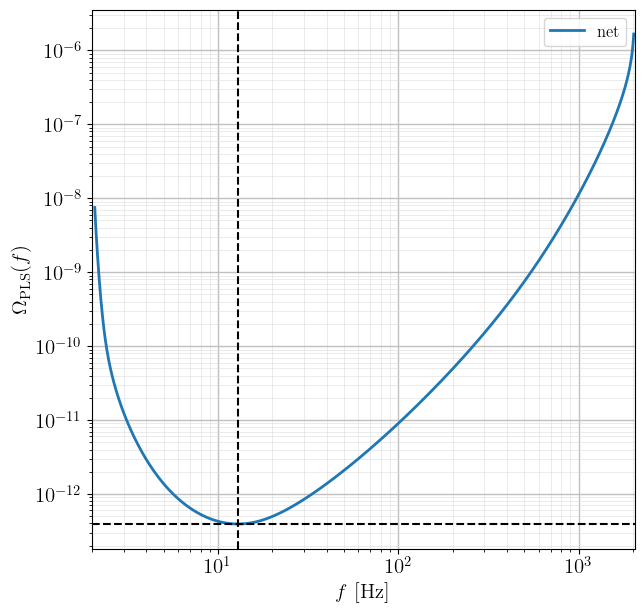

In [13]:
f_min, pls_min = st.powerlaw_integrated_sensitivity_minimum(fmin=fmin,
                                                            fmax=fmax,
                                                            Net=my_dets,
                                                            H0=67.66,
                                                            Tobs=1.,
                                                            return_all=False,
                                                           )
# Let's check the result for the whole network:
det = "net"
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.loglog(f[det], pls_exact[det], lw=2., label=det)
ax.axvline(x=f_min[det], linestyle="--", color="black", lw=1.5)
ax.axhline(y=pls_min[det], linestyle="--", color="black", lw=1.5)
ax.set_xlabel(r"$f$ [Hz]")
ax.set_xlim([fgrid[0], fgrid[-1]])
ax.set_ylabel(r"$\Omega_{\rm PLS}(f)$")
ax.grid(visible=True, which="major", color="silver", linewidth="1", linestyle="-")
ax.grid(visible=True, which="minor", color="gainsboro", linewidth="0.4", linestyle="-")
ax.legend(fontsize=12, ncols=2)


# Stochastic GW background SNR from cross-correlation

Given a network of detector and a GW spectrum, we can compute its SNR through the function `background_SNR_crosscorr`.

In [14]:
# Let's define a simple power-law like GW spectrum
omega_gw_amplitude = 1e-16
omega_gw_powerlaw = fgrid**(3.)
omega_gw = omega_gw_amplitude*omega_gw_powerlaw

# Showcase of array of omega_gw todo

# Compute the SNR of the network and all the detector pairs
snr = st.background_SNR_crosscorr(f=fgrid,
                                  omega_gw=omega_gw,
                                  Net=my_dets,
                                  H0=67.66,
                                  Tobs=1.,
                                  return_all=True,
                                 )

In [15]:
for key in snr.keys():
    print(f"SNR of Om_GW in {key}: {snr[key]:.1f}")

SNR of Om_GW in ETS_0-ETS_1: 10.2
SNR of Om_GW in ETS_0-ETS_2: 10.2
SNR of Om_GW in ETS_0-CE1Id: 0.1
SNR of Om_GW in ETS_0-CE2NM: 0.5
SNR of Om_GW in ETS_1-ETS_2: 10.2
SNR of Om_GW in ETS_1-CE1Id: 0.7
SNR of Om_GW in ETS_1-CE2NM: 0.1
SNR of Om_GW in ETS_2-CE1Id: 0.8
SNR of Om_GW in ETS_2-CE2NM: 0.6
SNR of Om_GW in CE1Id-CE2NM: 3.5
SNR of Om_GW in ETS: 17.7
SNR of Om_GW in net: 18.0


This function is vectorized and accepts array of power-law like GW spectra as well. Here is an example.

In [16]:
# Let's define an array of power-law like GW spectra
power_law_indexes = [-3., 0., 3.]
omega_gw_amplitude = 1e-16
omega_gw = np.array([omega_gw_amplitude*(fgrid**alpha) for alpha in power_law_indexes]).T # Has to be transposed for shape reasons

# Compute the SNR of the network and all the detector pairs for all the spectra:
snr = st.background_SNR_crosscorr(f=fgrid,
                                  omega_gw=omega_gw,
                                  Net=my_dets,
                                  H0=67.66,
                                  Tobs=1.,
                                  return_all=True,
                                 )

In [17]:
for alpha in power_law_indexes:
    print(f"\nOm_GW spectrum prop to f^({alpha})")
    for key in snr.keys():
        print(f"SNR of Om_GW in {key}: {snr[key][power_law_indexes.index(alpha)]:.1e}")


Om_GW spectrum prop to f^(-3.0)
SNR of Om_GW in ETS_0-ETS_1: 3.2e-07
SNR of Om_GW in ETS_0-ETS_2: 3.2e-07
SNR of Om_GW in ETS_0-CE1Id: 4.2e-08
SNR of Om_GW in ETS_0-CE2NM: 5.7e-08
SNR of Om_GW in ETS_1-ETS_2: 3.2e-07
SNR of Om_GW in ETS_1-CE1Id: 5.3e-08
SNR of Om_GW in ETS_1-CE2NM: 3.8e-08
SNR of Om_GW in ETS_2-CE1Id: 9.4e-08
SNR of Om_GW in ETS_2-CE2NM: 2.2e-08
SNR of Om_GW in CE1Id-CE2NM: 1.2e-07
SNR of Om_GW in ETS: 5.6e-07
SNR of Om_GW in net: 5.9e-07

Om_GW spectrum prop to f^(0.0)
SNR of Om_GW in ETS_0-ETS_1: 7.5e-05
SNR of Om_GW in ETS_0-ETS_2: 7.5e-05
SNR of Om_GW in ETS_0-CE1Id: 2.4e-05
SNR of Om_GW in ETS_0-CE2NM: 2.6e-05
SNR of Om_GW in ETS_1-ETS_2: 7.5e-05
SNR of Om_GW in ETS_1-CE1Id: 5.6e-05
SNR of Om_GW in ETS_1-CE2NM: 2.3e-05
SNR of Om_GW in ETS_2-CE1Id: 7.9e-05
SNR of Om_GW in ETS_2-CE2NM: 2.4e-05
SNR of Om_GW in CE1Id-CE2NM: 1.9e-04
SNR of Om_GW in ETS: 1.3e-04
SNR of Om_GW in net: 2.5e-04

Om_GW spectrum prop to f^(3.0)
SNR of Om_GW in ETS_0-ETS_1: 1.0e+01
SNR of Om_

# Minimum detectable energy density

With a single detector we are of course unable to cross-correlate the output with other interferometers. However, If the detector PSD is well characterized and a stochastic background stands out from it, it is in principle detectable. In total generality, we can determine the minimum value per frequency bin a stochastic signal should have to be detected by a single interferometer with a given SNR (see Eq.(7.215) of [Maggiore, Volume 1](https://global.oup.com/academic/product/gravitational-waves-9780198570745?q=Michele%20Maggiore&lang=en&cc=it)). We provide a function to access this value:

In [22]:
# Let's check it for CE1d
det = "CE1Id"
# Note that the sum of the average of the square of the pattern function is required
# For an L-shaped interferometer, this value is 2./5.
# For a triangular-shaped interferometer, this value is 3./10.
# If not specified in the function, the L-shaped value is assumed.
F = 2./5.
chosen_snr = 1.
min_omega_gw = st.minimum_detectable_energy_density_singleDet(f=fgrid,
                                                              Det=my_dets[det],
                                                              H0=67.66,
                                                              SNRval=chosen_snr,
                                                              pattern_Avg=F,
                                                             )

print(min_omega_gw)

[0.         0.         0.         ... 0.02829793 0.02830713 0.02831633]
